### Importing Libraries

In [66]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pyclustering.cluster.kmedians import kmedians
pd.set_option("display.max_columns",None)

### Importing datasets

In [67]:
df_hltb = pd.read_parquet("jrpgs_db.parquet")
df_igdb = pd.read_parquet("games_data.parquet")

### Adding prefix in order to differentiate where the data came from

In [68]:
df_hltb = df_hltb.add_prefix('hltb_')
df_igdb = df_igdb.add_prefix('igdb_')

### Merging datasets

In [69]:
df = df_hltb.merge(df_igdb, how="left", left_on=["hltb_game_name", "hltb_release_world"], right_on=["igdb_nome", "igdb_ano"])

In [70]:
df.sample(5)

,hltb_game_id,hltb_game_name,hltb_game_name_date,hltb_game_alias,hltb_game_type,hltb_game_image,hltb_comp_lvl_combine,hltb_comp_lvl_sp,hltb_comp_lvl_co,hltb_comp_lvl_mp,hltb_comp_main,hltb_comp_plus,hltb_comp_100,hltb_comp_all,hltb_comp_main_count,hltb_comp_plus_count,hltb_comp_100_count,hltb_comp_all_count,hltb_invested_co,hltb_invested_mp,hltb_invested_co_count,hltb_invested_mp_count,hltb_count_comp,hltb_count_speedrun,hltb_count_backlog,hltb_count_review,hltb_review_score,hltb_count_playing,hltb_count_retired,hltb_profile_platform,hltb_profile_popular,hltb_release_world,igdb_nome,igdb_ano,igdb_name,igdb_slug,igdb_rating,igdb_rating_count,igdb_summary,igdb_url,igdb_franchises,igdb_game_modes,igdb_genres,igdb_keywords,igdb_platforms,igdb_player_perspectives,igdb_themes,igdb_collections,igdb_release_year
1800,8023,Rune Factory: Tides of Destiny,0,Rune Factory: Oceans,game,8023_Rune_Factory_Tides_of_Destiny.jpg,0,1,1,1,227226,254611,359654,264056,11,19,10,40,0,0,0,0,72,0,329,41,76,1,25,"PlayStation 3, Wii",11,2011,Rune Factory: Tides of Destiny,2011.0,Rune Factory: Tides of Destiny,rune-factory-tides-of-destiny,55.240803,8.0,"Aden and Sonja, two lifelong friends, live a t...",https://www.igdb.com/games/rune-factory-tides-...,rune-factory,single-player,"role-playing-rpg, simulator","anime, dating, fishing, crafting, breeding, co...","wii, ps3",third-person,"action, sandbox, romance",rune-factory,NaN
1616,103309,Pokémon Rumble Rush,0,"Pokémon Scramble SP, Pokemon Rumble Rush",game,103309_Pokmon_Rumble_Rush.jpg,0,1,1,1,140400,576000,1483200,654600,1,1,1,3,0,0,0,0,6,0,2,4,35,0,7,Mobile,5,2019,Pokémon Rumble Rush,2019.0,Pokémon Rumble Rush,pokemon-rumble-rush,69.953665,8.0,A world full of uncharted islands! Aided by st...,https://www.igdb.com/games/pokemon-rumble-rush,pokemon,single-player,hack-and-slash-beat-em-up,None,"android, ios","third-person, bird-view-slash-isometric","action, fantasy",pokemon-rumble,NaN
1552,13881,Phantasy Star Adventure,0,,game,256px-Phantasy_Star_Adventure_-_Cover.jpg,0,1,1,1,5730,0,7576,5934,7,0,3,10,0,0,0,0,14,1,36,9,58,0,2,Sega Game Gear,6,1992,Phantasy Star Adventure,1992.0,Phantasy Star Adventure,phantasy-star-adventure,NaN,NaN,This game is a Japanese-style adventure game s...,https://www.igdb.com/games/phantasy-star-adven...,phantasy-star,single-player,"adventure, visual-novel","anime, death, melee",gamegear,text,"fantasy, science-fiction, mystery",phantasy-star,1992.0
2364,10969,Virtual Hydlide,0,,game,200px-Virtual_Hydlide_Box_Art.jpg,0,1,1,1,12372,29948,0,14085,7,1,0,8,0,0,0,0,10,0,27,4,68,0,2,Sega Saturn,5,1995,Virtual Hydlide,1995.0,Virtual Hydlide,virtual-hydlide,NaN,NaN,Action/RPG's don't get more real than this! Di...,https://www.igdb.com/games/virtual-hydlide,None,single-player,"role-playing-rpg, hack-and-slash-beat-em-up, a...","medieval, vampire, 2-5d, polygonal-3d, randoml...",saturn,third-person,"action, fantasy, horror, historical, sandbox",hydlide,NaN
1181,92446,Lost Judgment,0,Lost Judgment: Unjudged Memories,game,92446_Lost_Judgment.jpg,0,1,0,0,87600,192663,382558,175620,183,452,53,688,0,0,0,0,1206,1,1796,495,86,46,26,"PC, PlayStation 4, PlayStation 5, Xbox One, Xb...",246,2021,Lost Judgment,2021.0,Lost Judgment,lost-judgment,84.454027,41.0,Lost Judgment is an action-adventure video gam...,https://www.igdb.com/games/lost-judgment,yakuza-like-a-dragon,single-player,"role-playing-rpg, hack-and-slash-beat-em-up, a...","japan, yakuza","series-x-s, ps4--1, win, ps5, xboxone",third-person,"action, drama, mystery",judgment,NaN


### Pre-selecting what columns will be used for the models
Here i'm selecting solely based on what makes sense to be included or not. Later i'll use more robust techniques

In [71]:
columns = ['hltb_game_name', 'hltb_comp_main', 'hltb_comp_plus', 'hltb_comp_100', 'hltb_count_backlog', 'hltb_review_score', 'hltb_profile_popular', 'hltb_release_world', 'igdb_rating', 'igdb_game_modes', 'igdb_genres', 'igdb_keywords', 'igdb_platforms', 'igdb_player_perspectives', 'igdb_themes']

In [72]:
df_prd = df[columns]

### Applying Frequency Encoding to deal with categorical data

In [73]:
def frequency_encoding(df_, col):
    df_[col] = df_[col].fillna('')
    
    df_[col] = df_[col].apply(lambda x: x.split(', ') if x != '' else [])
    
    all_categories = [cat for sublist in df_[col] for cat in sublist]
    
    if not all_categories:
        return df_
    
    freq_map = pd.Series(all_categories).value_counts(normalize=True)
    
    df_[col] = df_[col].apply(lambda x: sum(freq_map[cat] for cat in x) / len(x) if len(x) > 0 else -1)
    
    return df_


In [74]:
df_prd.sample()

,hltb_game_name,hltb_comp_main,hltb_comp_plus,hltb_comp_100,hltb_count_backlog,hltb_review_score,hltb_profile_popular,hltb_release_world,igdb_rating,igdb_game_modes,igdb_genres,igdb_keywords,igdb_platforms,igdb_player_perspectives,igdb_themes
824,Front Mission 4,137258,182293,242104,251,76,16,2003,73.0,None,"role-playing-rpg, strategy, tactical","helicopter, mech, robots, war, artificial-inte...",ps2,None,science-fiction


In [75]:
cat_cols = ['igdb_game_modes', 'igdb_genres', 'igdb_keywords', 'igdb_platforms', 'igdb_player_perspectives', 'igdb_themes']

In [76]:
for cat_col in cat_cols:
    df_prd = frequency_encoding(df_=df_prd, col=cat_col)

C:\Users\menez\AppData\Local\Temp\ipykernel_16324\918673269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[col] = df_[col].fillna('')
C:\Users\menez\AppData\Local\Temp\ipykernel_16324\918673269.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[col] = df_[col].apply(lambda x: x.split(', ') if x != '' else [])
C:\Users\menez\AppData\Local\Temp\ipykernel_16324\918673269.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [77]:
df_prd.sample()

,hltb_game_name,hltb_comp_main,hltb_comp_plus,hltb_comp_100,hltb_count_backlog,hltb_review_score,hltb_profile_popular,hltb_release_world,igdb_rating,igdb_game_modes,igdb_genres,igdb_keywords,igdb_platforms,igdb_player_perspectives,igdb_themes
540,Drancia Saga,6473,0,0,10,67,6,2017,NaN,0.768632,0.008288,-1.0,0.035482,0.134773,0.293394


### Some columns have NaN values that need some kind of treatment. Hence, i'll create a new column signaling it and fill na with the median.

In [78]:
missing_cols = list(df_prd.columns[df_prd.isna().sum() > 0])

In [79]:
missing_cols

['igdb_rating']

In [80]:
for col in missing_cols:
    df_prd[f'flag_missing_{col}'] = df_prd[col].isna().astype(int)
    df_prd[col] = df_prd[col].fillna(df_prd[col].median())

C:\Users\menez\AppData\Local\Temp\ipykernel_16324\2840448509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prd[f'flag_missing_{col}'] = df_prd[col].isna().astype(int)
C:\Users\menez\AppData\Local\Temp\ipykernel_16324\2840448509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prd[col] = df_prd[col].fillna(df_prd[col].median())


In [81]:
df_prd

,hltb_game_name,hltb_comp_main,hltb_comp_plus,hltb_comp_100,hltb_count_backlog,hltb_review_score,hltb_profile_popular,hltb_release_world,igdb_rating,igdb_game_modes,igdb_genres,igdb_keywords,igdb_platforms,igdb_player_perspectives,igdb_themes,flag_missing_igdb_rating
0,.hack//G.U. Last Recode,184912,323464,463934,2799,75,202,2017,76.736407,0.768632,0.302528,0.005595,0.091596,0.361987,0.248908,0
1,.hack//G.U. Vol. 1: Rebirth,67404,86082,129765,315,75,31,2006,77.942879,0.768632,0.409242,0.004051,0.039819,0.219654,0.248908,0
2,.hack//G.U. Vol. 2: Reminisce,71780,109476,167682,291,78,32,2006,67.344444,0.768632,0.409242,0.018395,0.039819,0.219654,0.226665,0
3,.hack//G.U. Vol. 3: Redemption,75792,112582,166687,289,77,32,2007,70.000000,0.768632,0.409242,0.018395,0.039819,0.361987,0.226665,0
4,.hack//Link,104050,152060,176400,74,57,11,2010,75.820311,0.768632,0.409242,-1.000000,0.039030,0.361987,0.196710,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2532,Zoids Saga,0,0,0,5,0,5,2001,75.820311,-1.000000,0.409242,-1.000000,0.015376,-1.000000,-1.000000,1
2533,Zoids: Legacy,81000,91800,228600,39,83,5,2004,75.820311,0.768632,0.409242,-1.000000,0.015376,0.265011,0.100027,1
2534,Zombie Hunter,14400,16200,0,8,55,7,1987,75.820311,0.768632,0.409242,0.006265,0.008870,-1.000000,0.157529,1
2535,Zone of the Enders: The Fist of Mars,61287,63000,78450,109,70,13,2001,70.687179,0.768632,0.181862,0.002539,0.015376,-1.000000,0.196710,0


### Selecting features that will be used in clustering

#### VarianceThreshold
The features that have to little variance usually don't help in the process of clustering

In [82]:
df_num = df_prd[['hltb_comp_main','hltb_comp_plus','hltb_comp_100','hltb_count_backlog','hltb_review_score','hltb_profile_popular','hltb_release_world','igdb_rating','igdb_game_modes','igdb_genres','igdb_keywords','igdb_platforms','igdb_player_perspectives','igdb_themes','flag_missing_igdb_rating']]

In [83]:
variances = df_num.var()

In [84]:
variances_concat = pd.concat([variances, variances >= 0.01, variances >= 0.05, variances >= 0.1], axis=1).rename(columns={0:"Variance", 1:"1%", 2:"5%", 3:"10%"})
variances_concat

,Variance,1%,5%,10%
hltb_comp_main,5.710792e+09,True,True,True
hltb_comp_plus,4.502633e+10,True,True,True
hltb_comp_100,9.075892e+10,True,True,True
hltb_count_backlog,2.159798e+06,True,True,True
hltb_review_score,8.066613e+02,True,True,True
hltb_profile_popular,2.272768e+04,True,True,True
hltb_release_world,1.748642e+04,True,True,True
igdb_rating,7.328641e+01,True,True,True
igdb_game_modes,4.369997e-01,True,True,True
igdb_genres,1.688403e-01,True,True,True


The variance on all features are higher than 1% and 5%. The variance in igdb_platforms isn't higher than 10%, but this feature its categorical, hence, it will stay in the dataframe

#### Correlation Between Features
If 2 or more columns have high correlation, i'll choose one to keep and drop the other(s)

In [85]:
corr_matrix  = df_num.corr()

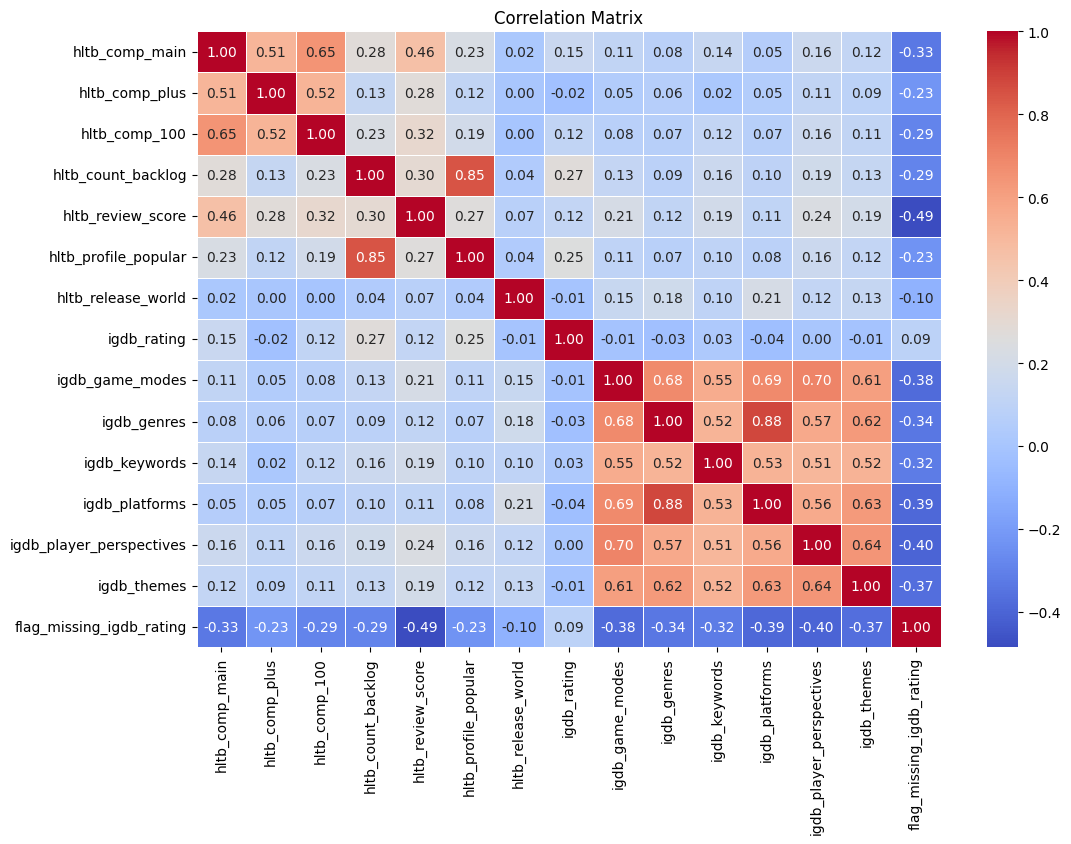

In [86]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

Due to high correlation between 'hltb_count_backlog' and 'hltb_profile_popular', and between 'igdb_genres' and 'igdb_platforms', i chose to keep only one of them

In [87]:
cols_to_keep = ['hltb_comp_main', 'hltb_comp_plus','hltb_comp_100', 'hltb_review_score','hltb_profile_popular','hltb_release_world','igdb_rating','igdb_game_modes','igdb_genres','igdb_keywords','igdb_player_perspectives','igdb_themes','flag_missing_igdb_rating']
df_num_2 = df_num[cols_to_keep]

### Building the Models

I'll use the silhouette score to help me find the best k<br>
<br>
The Silhouette Score is a metric that evaluates the quality of clusters found by a clustering algorithm. It measures how well each point fits within its own cluster and how far it is from other clusters.<br><br>

The formula for the Silhouette Score for a point ii is:
<br>
<br>
<br>
<br>
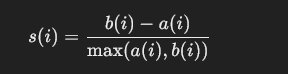
<br>
<br>
Where:
<br><br>
    a(i) = Average distance between ii and all other points in the same cluster.
<br><br>
    b(i) = Average distance between ii and all points in the nearest cluster to which it does not belong.
<br><br>
    s(i) ranges between -1 and 1.
<br><br>
Interpretation of Silhouette Score values:
<br><br>
    s(i) close to 1 → The point is well-grouped within its cluster and far from other clusters (excellent clustering).
<br><br>
    s(i) close to 0 → The point is on the boundary between clusters (may indicate overlapping clusters).
<br><br>
    s(i) negative → The point may be in the wrong cluster, as it is closer to another cluster.

In [88]:
def find_best_k(X, k_range):
    best_k = None
    best_score = -1
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        print(f'k={k}, Silhouette Score={score:.4f}')
        
        if score > best_score:
            best_k = k
            best_score = score
            
    return best_k

k_range = range(2, 30)
best_k = find_best_k(df_num_2, k_range)
print(f'Best: {best_k}')


k=2, Silhouette Score=0.7248
k=3, Silhouette Score=0.6172
k=4, Silhouette Score=0.5854
k=5, Silhouette Score=0.5678
k=6, Silhouette Score=0.5427
k=7, Silhouette Score=0.5433
k=8, Silhouette Score=0.4914
k=9, Silhouette Score=0.4938
k=10, Silhouette Score=0.4499
k=11, Silhouette Score=0.4716
k=12, Silhouette Score=0.4829
k=13, Silhouette Score=0.4557
k=14, Silhouette Score=0.4872
k=15, Silhouette Score=0.4540
k=16, Silhouette Score=0.4311
k=17, Silhouette Score=0.4515
k=18, Silhouette Score=0.4583
k=19, Silhouette Score=0.4602
k=20, Silhouette Score=0.4308
k=21, Silhouette Score=0.4375
k=22, Silhouette Score=0.4402
k=23, Silhouette Score=0.4455
k=24, Silhouette Score=0.4391
k=25, Silhouette Score=0.4138
k=26, Silhouette Score=0.4206
k=27, Silhouette Score=0.4204
k=28, Silhouette Score=0.4230
k=29, Silhouette Score=0.4246
Best: 2


In [89]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(df_num_2)

I don't really know much about PCA, but, it seems it can be used to reduce dimensionality, which will allow me to visualize a chart over the model

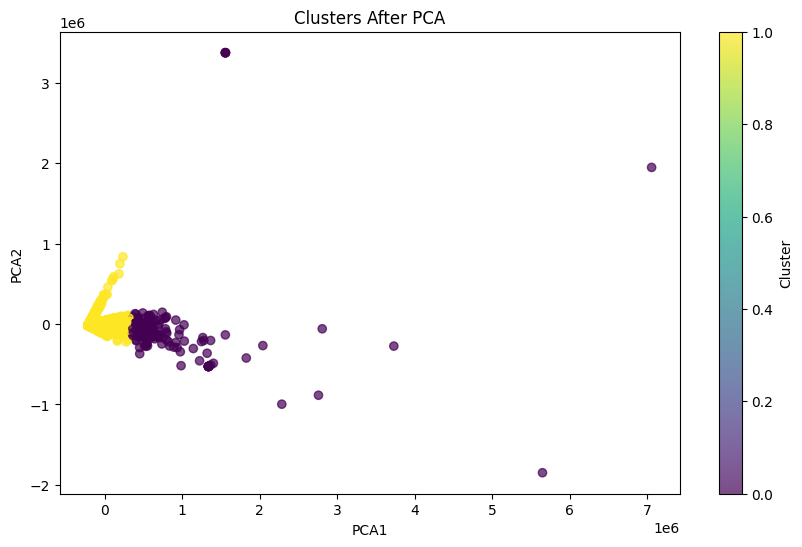

In [90]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_num_2)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Clusters After PCA")
plt.show()

Yeah, that's pretty bad...

Now i'll try to find the k games closest to my input game (chatGPT helped me)

In [91]:
from scipy.spatial.distance import cdist

def find_similar_games(game_name, df, X, k=5):
    # Encontrar a posição do jogo no dataframe
    game_idx = df[df.iloc[:, 0] == game_name].index[0]
    
    # Obter a feature do jogo escolhido
    game_vector = X[game_idx].reshape(1, -1)
    
    # Calcular as distâncias para todos os outros jogos
    distances = cdist(game_vector, X, metric='euclidean').flatten()
    
    # Obter os índices dos k mais próximos (ignorando o próprio jogo)
    closest_idxs = np.argsort(distances)[1:k+1]  # [1:k+1] para ignorar o próprio jogo
    
    # Retornar os nomes dos jogos mais próximos
    return df.iloc[closest_idxs, 0].values


In [92]:
X = df_num_2.values

In [93]:
similar_games = find_similar_games("Chrono Trigger", df_prd, X, k=10)
print("Jogos mais similares:", similar_games)

Jogos mais similares: ['Chrono Trigger' 'Chrono Trigger' 'Chrono Trigger'
 'Brave Story: New Traveler' 'Metal Gear Acid' 'Dragon Quest Treasures'
 'Trials of Mana' 'Trials of Mana' 'Trials of Mana' 'Trials of Mana']


In [94]:
similar_games = find_similar_games("Final Fantasy VI", df_prd, X, k=10)
print("Jogos mais similares:", similar_games)

Jogos mais similares: ['Innocent Life: A Futuristic Harvest Moon'
 'The Witch and the Hundred Knight 2' 'Danganronpa 2: Goodbye Despair'
 'Atelier Iris 3: Grand Phantasm' 'Beyond the Labyrinth' 'SaGa Frontier 2'
 'Shin Megami Tensei: Digital Devil Saga 2'
 'Dragon Quest III HD-2D Remake' 'Fire Emblem: Thracia 776'
 'Xenosaga Episode III: Also sprach Zarathustra']


That's also bad...